In [ ]:
import os
import numpy as np
import time
import random
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape  == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape  == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [ ]:
# Split train dataset into train and validation
X_val   = X_train[50000:60000]
X_train = X_train[0:50000]
y_val   = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

In [ ]:
#Normalize Data

X_train = X_train/255
X_val   = X_val/255
X_test  = X_test/255

print(f'max: ', np.max(X_train))
print(f'min: ', np.min(X_train))

In [ ]:
size_input = X_train.shape[1]

size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128

size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples  = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(tf.shape(y_val))

In [ ]:
# Define class to build mlp model
class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        """
        self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
        size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device

        # Initialize weights between input mapping and a layer g(f(x)) = layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
        # Initialize biases for hidden layer
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)

        # Initialize weights between input layer and 1st hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
        # Initialize biases for hidden layer
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights between 1st hidden layer and 2nd hidden layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
        # Initialize biases for hidden layer
        self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))

         # Initialize weights between 2nd hidden layer and output layer
        self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
        # Initialize biases for output layer
        self.b4 = tf.Variable(tf.zeros([1, self.size_output]))

        # Initializing gamma and beta for all the layers for batch norm
        self.gamma = {"1": tf.Variable(tf.ones(self.W1.shape[-1])),
                      "2": tf.Variable(tf.ones(self.W2.shape[-1])),
                      "3": tf.Variable(tf.ones(self.W3.shape[-1]))
        }
        self.beta  = {"1": tf.Variable(tf.zeros(self.W1.shape[-1])),
                      "2": tf.Variable(tf.zeros(self.W2.shape[-1])),
                      "3": tf.Variable(tf.zeros(self.W3.shape[-1]))
        }
        # Define variables to be updated during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.W4, 
                          self.b1, self.b2, self.b3, self.b4, 
                          self.gamma["1"], self.beta["1"], 
                          self.gamma["2"], self.beta["2"], 
                          self.gamma["3"], self.beta["3"]]

        self.mean = {"1": tf.Variable(tf.zeros(self.W1.shape[-1])),
                     "2": tf.Variable(tf.zeros(self.W2.shape[-1])),
                     "3": tf.Variable(tf.zeros(self.W3.shape[-1]))
        }
        self.var = {"1": tf.Variable(tf.zeros(self.W1.shape[-1])),
                    "2": tf.Variable(tf.zeros(self.W2.shape[-1])),
                    "3": tf.Variable(tf.zeros(self.W3.shape[-1]))
        }
  
    def forward(self, X, run):
        """
        forward pass
        X: Tensor, inputs
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                if run == "train":
                    self.y = self.compute_output_train(X)
                else:
                    self.y = self.compute_output_test(X)
        else:
            if run == "train":
                self.y = self.compute_output_train(X)
            else:
                self.y = self.compute_output_test(X)

        return self.y

    def loss(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_true_tf = tf.cast(y_true, dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss_x = cce(y_true_tf, y_pred_tf)
        # Use keras or tf_softmax, both should work for any given model
        #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))

        return loss_x

    def backward(self, X_train, y_train, opti):
        """
        backward pass
        """
        optimizer = opti

        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, "train")
            current_loss = self.loss(predicted, y_train)

        grads = tape.gradient(current_loss, self.variables)
        optimizer.apply_gradients(zip(grads, self.variables))
        
    def batch_norm(self, inputs, layer):
        mean, var = tf.nn.moments(inputs, [0])
        self.mean[layer] = 0.9*self.mean[layer] + 0.1*mean
        self.var[layer]  = 0.9*self.var[layer]  + 0.1*var
        
        return tf.add(tf.divide(tf.multiply(self.gamma[layer], tf.subtract(inputs, mean)), tf.sqrt(var+1e-8)), self.beta[layer])

    def compute_output_train(self, X):
        """
        Custom method to obtain output tensor during forward pass
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        #X_tf = X

        # Compute values in hidden layers
        z1 = tf.matmul(X_tf, self.W1) + self.b1
        z1 = self.batch_norm(z1, "1")
        h1 = tf.nn.relu(z1)

        z2 = tf.matmul(h1, self.W2) + self.b2
        z2 = self.batch_norm(z2, "2")
        h2 = tf.nn.relu(z2)

        z3 = tf.matmul(h2, self.W3) + self.b3
        z3 = self.batch_norm(z3, "3")
        h3 = tf.nn.relu(z3)

        # Compute output
        output = tf.matmul(h3, self.W4) + self.b4
        #output = self.batch_norm(output, "4")
        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
        # Second add tf.Softmax(output) and then return this variable
        return (output)
    
    def compute_output_test(self, X):
        """
        Custom method to obtain output tensor during forward pass
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)
        #X_tf = X

        # Compute values in hidden layers
        z1 = tf.matmul(X_tf, self.W1) + self.b1
        z1 = tf.add(tf.divide(tf.multiply(self.gamma["1"], tf.subtract(z1, self.mean["1"])), tf.sqrt(self.var["1"])), self.beta["1"])
        h1 = tf.nn.relu(z1)

        z2 = tf.matmul(h1, self.W2) + self.b2
        z2 = tf.add(tf.divide(tf.multiply(self.gamma["2"], tf.subtract(z2, self.mean["2"])), tf.sqrt(self.var["2"])), self.beta["2"])
        h2 = tf.nn.relu(z2)

        z3 = tf.matmul(h2, self.W3) + self.b3
        z3 = tf.add(tf.divide(tf.multiply(self.gamma["3"], tf.subtract(z3, self.mean["3"])), tf.sqrt(self.var["3"])), self.beta["3"])
        h3 = tf.nn.relu(z3)

        # Compute output
        output = tf.matmul(h3, self.W4) + self.b4

        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
        # Second add tf.Softmax(output) and then return this variable
        return (output)




***************** Running MLP with pre-activation Batch Normalization for seed 2977 *****************


Train Accuracy: 0.8617
Number of Epoch = 1 - Average Cross Entropy:= 0.004356533813476562 

Validation Accuracy: 0.8495

Train Accuracy: 0.8788
Number of Epoch = 2 - Average Cross Entropy:= 0.0029947314453125 

Validation Accuracy: 0.8659

Train Accuracy: 0.8902
Number of Epoch = 3 - Average Cross Entropy:= 0.002642081604003906 

Validation Accuracy: 0.8721

Train Accuracy: 0.9009
Number of Epoch = 4 - Average Cross Entropy:= 0.0024121412658691405 

Validation Accuracy: 0.8759

Train Accuracy: 0.9096
Number of Epoch = 5 - Average Cross Entropy:= 0.002219288635253906 

Validation Accuracy: 0.8788

Train Accuracy: 0.9147
Number of Epoch = 6 - Average Cross Entropy:= 0.002058863525390625 

Validation Accuracy: 0.8795

Train Accuracy: 0.9211
Number of Epoch = 7 - Average Cross Entropy:= 0.001903658447265625 

Validation Accuracy: 0.8822

Train Accuracy: 0.9256
Number of Epoch = 8 - Ave

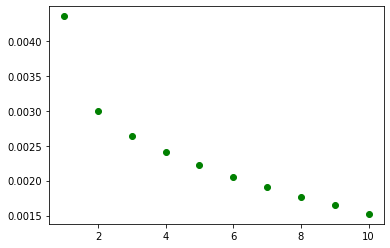


Total time taken (in seconds): 107.32
Test loss: 0.0958

Test Accuracy: 0.87


***************** Running MLP with pre-activation Batch Normalization for seed 1427 *****************


Train Accuracy: 0.8587
Number of Epoch = 1 - Average Cross Entropy:= 0.00438836181640625 

Validation Accuracy: 0.8476

Train Accuracy: 0.8780
Number of Epoch = 2 - Average Cross Entropy:= 0.0030348040771484377 

Validation Accuracy: 0.8601

Train Accuracy: 0.8888
Number of Epoch = 3 - Average Cross Entropy:= 0.0026650567626953126 

Validation Accuracy: 0.8650

Train Accuracy: 0.9002
Number of Epoch = 4 - Average Cross Entropy:= 0.0024279241943359377 

Validation Accuracy: 0.8714

Train Accuracy: 0.9047
Number of Epoch = 5 - Average Cross Entropy:= 0.0022358851623535156 

Validation Accuracy: 0.8710

Train Accuracy: 0.9112
Number of Epoch = 6 - Average Cross Entropy:= 0.002071214599609375 

Validation Accuracy: 0.8748

Train Accuracy: 0.9190
Number of Epoch = 7 - Average Cross Entropy:= 0.0019120587158203

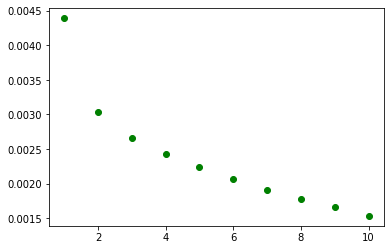


Total time taken (in seconds): 115.79
Test loss: 0.1016

Test Accuracy: 0.87


***************** Running MLP with pre-activation Batch Normalization for seed 9846 *****************


Train Accuracy: 0.8614
Number of Epoch = 1 - Average Cross Entropy:= 0.004333209228515625 

Validation Accuracy: 0.8449

Train Accuracy: 0.8805
Number of Epoch = 2 - Average Cross Entropy:= 0.0029972756958007813 

Validation Accuracy: 0.8608

Train Accuracy: 0.8918
Number of Epoch = 3 - Average Cross Entropy:= 0.0026356414794921875 

Validation Accuracy: 0.8692

Train Accuracy: 0.9004
Number of Epoch = 4 - Average Cross Entropy:= 0.0024016685485839843 

Validation Accuracy: 0.8744

Train Accuracy: 0.9084
Number of Epoch = 5 - Average Cross Entropy:= 0.002214339141845703 

Validation Accuracy: 0.8771

Train Accuracy: 0.9153
Number of Epoch = 6 - Average Cross Entropy:= 0.0020412139892578124 

Validation Accuracy: 0.8782

Train Accuracy: 0.9199
Number of Epoch = 7 - Average Cross Entropy:= 0.001905663452148

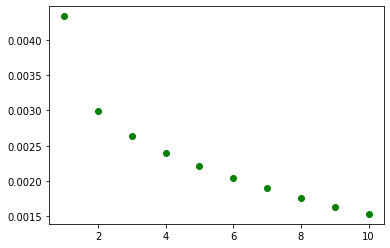


Total time taken (in seconds): 111.65
Test loss: 0.0923

Test Accuracy: 0.88


In [10]:
seeds = random.sample(range(1000, 9999), 3)
for trail in range(3):
    
    seed = seeds[trail]
    
    print(f'\n\n***************** Running MLP with pre-activation Batch Normalization for seed {seed} *****************\n')
    # Set number of epochs
    NUM_EPOCHS = 10

    # Initialize model using CPU
    mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

    time_start = time.time()
    opti = tf.keras.optimizers.SGD(learning_rate = 0.1)

    for epoch in range(NUM_EPOCHS):
        loss_total = tf.zeros([1,1], dtype=tf.float32)
        lt = 0

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
        kz = 0
        accuracy_z = 0.0
        cur_train_acc = 0.0
        for inputs, outputs in train_ds:
            qw, tr = tf.shape(inputs)
            kz = kz + 1
            preds = mlp_on_gpu.forward(inputs, "train") 
            loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
            lt = lt + mlp_on_gpu.loss(preds, outputs)
            mlp_on_gpu.backward(inputs, outputs, opti)

        preds = mlp_on_gpu.forward(X_train, "train")
        # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
        preds = tf.nn.softmax(preds)
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
        accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
        cur_train_acc += accuracy_z.numpy()
        ds = cur_train_acc
        print('\nTrain Accuracy: {:.4f}'.format(ds))
        print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
        preds_val = mlp_on_gpu.forward(X_val, "train")
        preds_val = tf.nn.softmax(preds_val)
        correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        cur_val_acc = accuracy.numpy()

        print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))

        plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')
        

    time_taken = time.time() - time_start
    plt.show()
    # Validate model



    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
    #For per epoch_time = Total_Time / Number_of_epochs

    test_loss_total = tf.Variable(0, dtype=tf.float32)
    correct_prediction = tf.Variable(0, dtype=tf.float32)


    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


    #test_loss_total = 0.0
    for inputs, outputs in test_ds:
        preds = mlp_on_gpu.forward(inputs, "test")
        test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)
    print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

    # Test model
    preds_test = mlp_on_gpu.forward(X_test, "test")
    preds_test = tf.nn.softmax(preds_test)
    correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_test_acc = accuracy.numpy()
    print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))